In [114]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras import layers
from matplotlib import pyplot as plt

In [115]:
def moving_zscore(df, window_size):
    df_norm = df.copy()
    for col in df_norm.columns:
        df_norm[col] = (df_norm[col] - df_norm[col].rolling(window=window_size,min_periods=1).mean()) / (df_norm[col].rolling(window=window_size,min_periods=1).std())
    df_norm = df_norm.dropna() 
    return df_norm

def zscore(df, df_train):
    training_mean = df_train.mean()
    training_std = df_train.std()

    df_norm = (df - training_mean) / training_std
    df_norm = df_norm.dropna() 
    return df_norm 

def segmentation(df, window_size):
    segments = []
    num_segments = len(df) - window_size + 1
    for i in range(num_segments):
        segment = df.iloc[i:i+window_size, :]
        segments.append(segment)
    return segments

def get_index(df,col_name_list):
    index_list=[]
    for name in col_name_list:
        index = df.columns.get_loc(name)
        index_list.append(index)
    return index_list

In [197]:
#Select data corresponding to a certain DMA
window_size = 8640
window_seg = 288
#DMAs
sensor_list1=['n1','n4','n31']
sensor_list2=['n410', 'n54', 'n429']
sensor_list3=['n644','n636','n342']
sensor_list4=['n296', 'n740', 'n722', 'n679' ]
sensor_list5=['n769','n752','n726','n288']
sensor_list7=['n188','n163','n613']
sensor_list=sensor_list5
df = pd.read_csv('C:/Users/mirip/Desktop/interdisciplinary/InterdisciplinaryProject/Data/2019_SCADA_Pressures.csv', sep=';')
indexes= get_index(df, sensor_list)
for column in df.columns[1:]:
    df[column] = pd.to_numeric(df[column].str.replace(',', '.'))


In [198]:
#define train and test
df_train = df.iloc[:4033, indexes]
df_test = df.iloc[4034:, indexes]


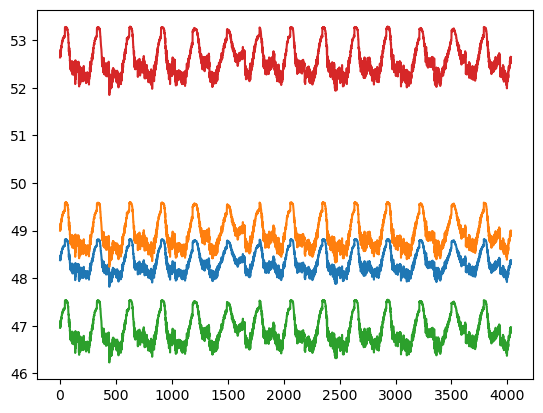

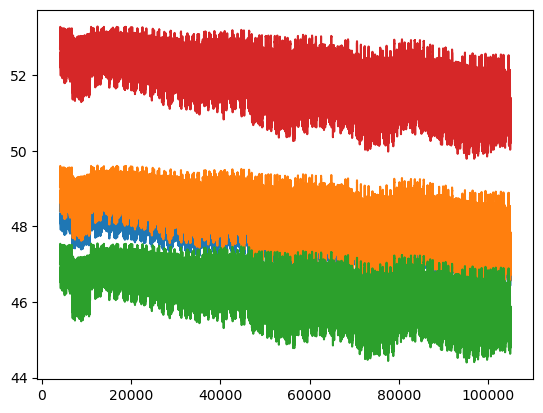

In [199]:
#plot train and test data

fig, ax = plt.subplots()
df_train[sensor_list].plot(legend=False, ax=ax)
plt.show()

fig, ax = plt.subplots()
df_test[sensor_list].plot(legend=False, ax=ax)
plt.show()


In [119]:
#smooth the data usinf rolling mean ----> worsen performances
'''
#rolling mean
ws=12
df_train= df_train.rolling(window=ws).mean()
df_train = df_train.dropna()

df_test= df_test.rolling(window=ws).mean()
df_test = df_test.dropna()'''

'\n#rolling mean\nws=12\ndf_train= df_train.rolling(window=ws).mean()\ndf_train = df_train.dropna()\n\ndf_test= df_test.rolling(window=ws).mean()\ndf_test = df_test.dropna()'

Number of training samples: 4033


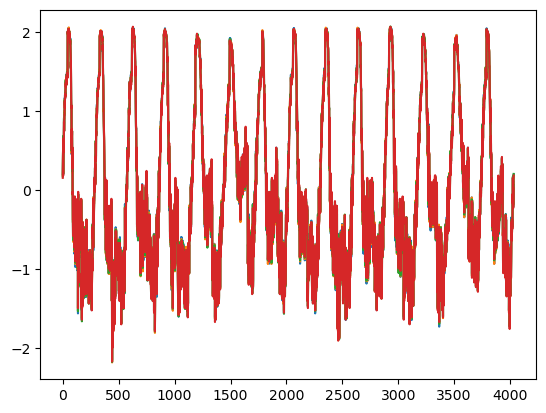

In [200]:
#apply z-score to train and plot
df_train_value=zscore(df_train,df_train)
print("Number of training samples:", len(df_train_value))

fig, ax = plt.subplots()
df_train_value[sensor_list].plot(legend=False, ax=ax)
plt.show()

In [201]:
#apply segmentation to train
x_train=segmentation(df_train_value, window_seg)
x_train=np.array(x_train)

In [202]:
#define the neural network
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="tanh",
        ),
        layers.AveragePooling1D(pool_size=2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="tanh",
        ),
        layers.AveragePooling1D(pool_size=2),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=4,
            activation="tanh",
        ),
        layers.AveragePooling1D(pool_size=2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=4,
            activation="tanh",
        ),
        layers.AveragePooling1D(pool_size=2),
        #last layer
        layers.Flatten(),
        layers.Dense(288 * len(sensor_list), activation='linear'),
        layers.Reshape((288, len(sensor_list)))
    ]
)


In [203]:
#compile and fit

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=144,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss")
    ],
)





Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 288, 32)           928       
                                                                 
 average_pooling1d_32 (Aver  (None, 144, 32)           0         
 agePooling1D)                                                   
                                                                 
 conv1d_17 (Conv1D)          (None, 144, 16)           3600      
                                                                 
 average_pooling1d_33 (Aver  (None, 72, 16)            0         
 agePooling1D)                                                   
                                                                 
 conv1d_transpose_16 (Conv1  (None, 288, 16)           1808      
 DTranspose)                                                     
                                                      

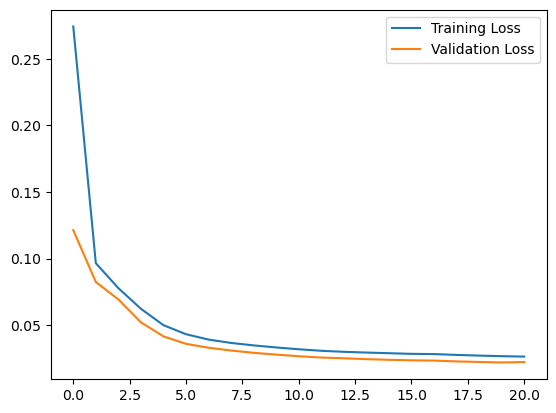

In [204]:
#training and validation loss plot
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [205]:
#predict on trainin g and evaluate maximum average error
x_train_pred = model.predict(x_train)

#sensor list in tutto codice
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

#partial sensor list
#indexes=get_index(df_train,sensor_list1)
#train_mae_loss = np.mean(np.abs(x_train_pred[:,indexes] - x_train[:,indexes]), axis=1)

118/118 [==============================] - 1s 9ms/step


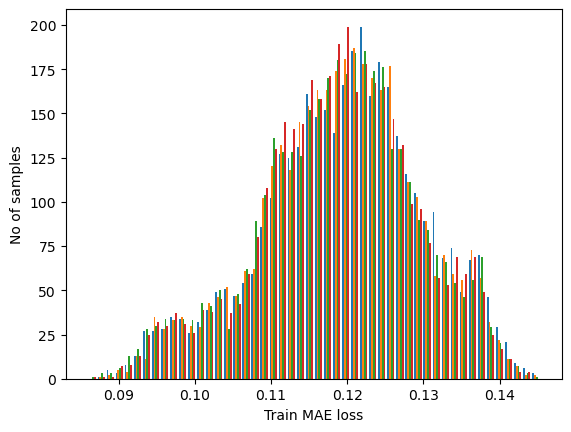

In [206]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()


In [207]:
#Threshold definition

threshold = 8*np.max(train_mae_loss)
# For example, setting threshold at 95th percentile
#threshold = np.percentile(train_mae_loss, 90)
#4 funziona con 15* max
#threshold = np.mean(train_mae_loss) + 3*np.std(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
#threshold=0.12



Reconstruction error threshold:  1.162685986266923


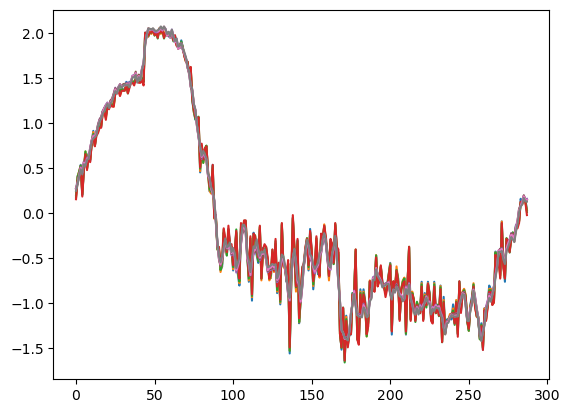

In [208]:


plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

# plt.plot(x_train[0,:,0])
# plt.plot(x_train_pred[0,:,0])
# plt.show()
# plt.plot(x_train[0,:,1])
# plt.plot(x_train_pred[0,:,1])
# plt.show()
# plt.plot(x_train[0,:,2])
# plt.plot(x_train_pred[0,:,2])
# plt.show()

#df_test=df_test.drop('Timestamp', axis=1)
#df_test_value = moving_zscore(df_test,window_size)



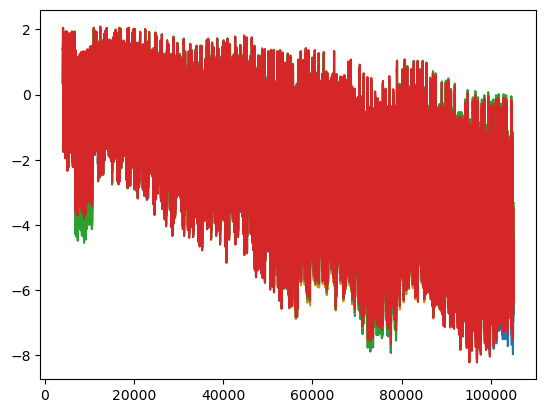

3150/3150 [==============================] - 28s 9ms/step
<class 'numpy.ndarray'>
(100799, 4)
[[0.12278417 0.12452712 0.12419666 0.12425639]
 [0.12536889 0.12840102 0.12728692 0.1271586 ]
 [0.12733981 0.1280995  0.12787867 0.12750222]
 ...
 [2.28433578 1.85550166 1.75780951 1.87304866]
 [2.28657778 1.85621145 1.76141349 1.87677463]
 [2.28237094 1.8555321  1.75892037 1.87207384]]


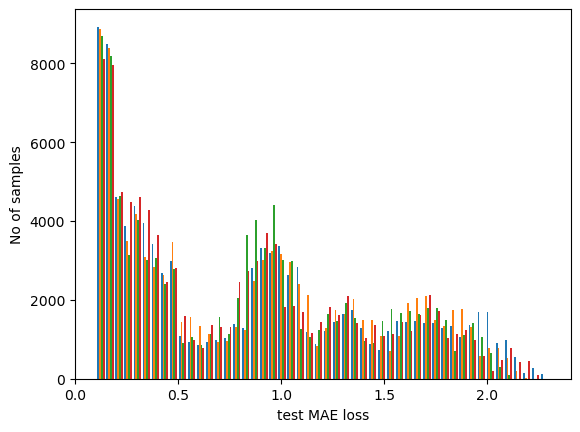

In [209]:
#same preprocessing and predict on test
df_test_value= zscore(df_test,df_train)
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

x_test = segmentation(df_test_value, window_seg)
x_test = np.array(x_test)

x_test_pred = model.predict(x_test)

#sensor list fissa
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

#sensor list parziale
#test_mae_loss = np.mean(np.abs(x_test_pred[:,indexes] - x_test[:,indexes]), axis=1)

print(type(test_mae_loss))
print(test_mae_loss.shape)
print(test_mae_loss)

#per plot con tutti i sensori
#test_mae_loss_tot = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

#per plot con tutti i sensori 
#print(test_mae_loss_tot.shape )
#plt.hist(test_mae_loss_tot, bins=50)
#plt.xlabel("test MAE loss tot")
#plt.ylabel("No of samples")
#plt.show()



(100799, 4)
<class 'numpy.ndarray'>
[[False False False False]
 [False False False False]
 [False False False False]
 ...
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
Number of anomaly samples:  29964
Indices of anomaly samples:  (array([ 50493,  50494,  50495, ..., 100796, 100797, 100798], dtype=int64),)
Number of anomaly samples in column 0: 29584
Indices of anomaly samples in column 0: [ 50498  50499  50500 ... 100796 100797 100798]
Number of anomaly samples in column 1: 29854
Indices of anomaly samples in column 1: [ 50493  50494  50495 ... 100796 100797 100798]
Number of anomaly samples in column 2: 28228
Indices of anomaly samples in column 2: [ 50510  50514  50516 ... 100796 100797 100798]
Number of anomaly samples in column 3: 28375
Indices of anomaly samples in column 3: [ 50520  50521  50522 ... 100796 100797 100798]


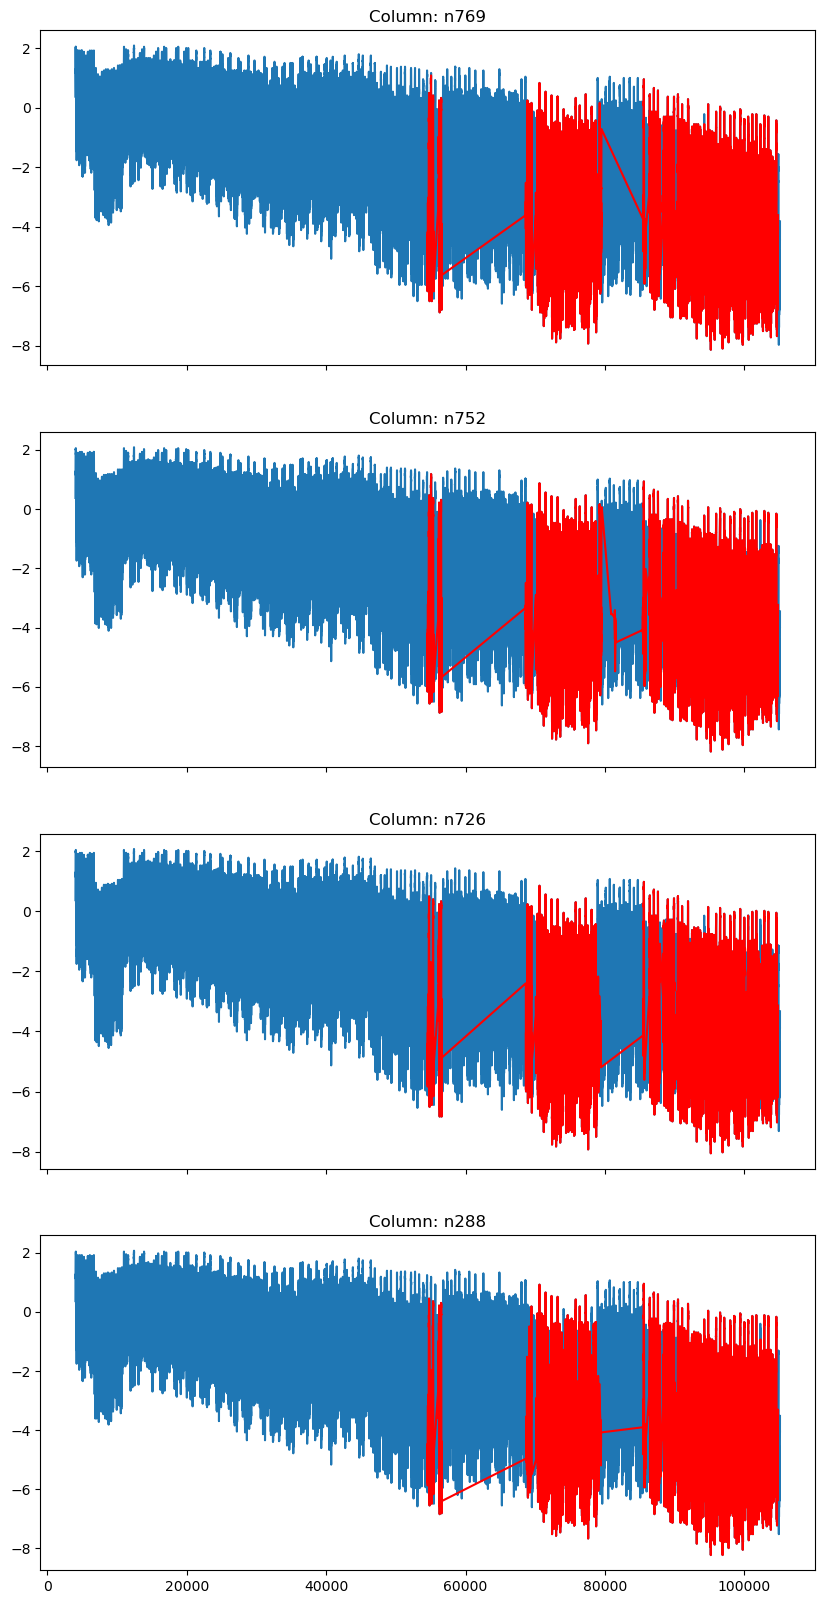

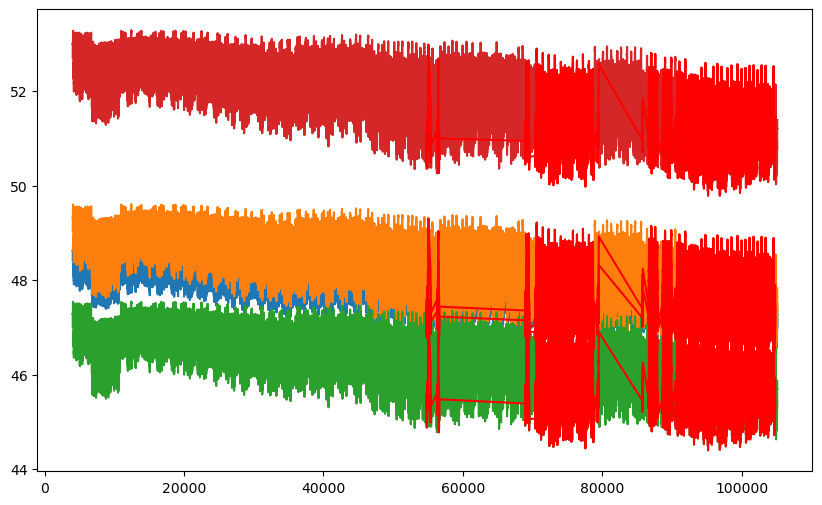

In [210]:
anomalies = test_mae_loss > threshold
print(anomalies.shape)
print(type(anomalies))

#all anomalous timestamps
anomalies_tot= np.any(anomalies, axis=1)

print(anomalies)
print("Number of anomaly samples: ", np.sum(anomalies_tot))
print("Indices of anomaly samples: ", np.where(anomalies_tot))

for i in range(anomalies.shape[1]):
    column_anomalies = anomalies[:, i]
    num_anomalies = np.sum(column_anomalies)
    anomaly_indices = np.where(column_anomalies)[0]
    print(f"Number of anomaly samples in column {i}: {num_anomalies}")
    print(f"Indices of anomaly samples in column {i}: {anomaly_indices}")


anomaly_indices_per_column = {}

# for single sensors iterate over the columns
for column in range(len(anomalies[0])):
    #empty list to store anomaly indices for this column
    anomaly_indices_per_column[column] = []
    for data_idx in range(window_seg - 1, len(df_test_value) - window_seg + 1):
        # Check if the value in this column is an anomaly
        if anomalies[data_idx, column]:
            # Append 
            anomaly_indices_per_column[column].append(data_idx)

# Select subset of data containing only anomalous samples for each column
df_subset_per_column = {}
for column, indices in anomaly_indices_per_column.items():
    df_subset_per_column[column] = df_test_value.iloc[indices]
    

# Plot the original data and the subset of anomalous data for each column
fig, axes = plt.subplots(len(df_test_value.columns), 1, figsize=(10, 5 * len(df_test_value.columns)), sharex=True)
for i, column_name in enumerate(df_test_value.columns):
    ax = axes[i]
    df_test_value[column_name].plot(legend=False, ax=ax)
    df_subset_per_column[i][column_name].plot(legend=False, ax=ax, color="r")
    ax.set_title(f"Column: {column_name}")
plt.show()

#for the plor containing data about all sensor in the dma
anomalous_data_indices_tot = []
for data_idx in range(window_seg - 1, len(df_test_value) - window_seg + 1):
    if np.all(anomalies_tot[data_idx - window_seg + 1 : data_idx]):
        anomalous_data_indices_tot.append(data_idx)

        
df_subset = df_test.iloc[anomalous_data_indices_tot]
fig, ax = plt.subplots(figsize=(10, 6))  
df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()


In [195]:
import os
import pandas as pd


anomalies_df = pd.DataFrame(anomalies, columns=df_test.columns)
print(anomalies_df.head)

file_exists = os.path.isfile('C:/Users/mirip/Desktop/interdisciplinary/InterdisciplinaryProject/anomalies.csv')

if file_exists:
    # File exists, overwrite its contents
    anomalies_df.to_csv('C:/Users/mirip/Desktop/interdisciplinary/InterdisciplinaryProject/anomalies.csv', mode='w')
    print('wwwwwwwwwwwwwwwwwwwwwwww')
else:
    # File doesn't exist, create a new one
    anomalies_df.to_csv('C:/Users/mirip/Desktop/interdisciplinary/InterdisciplinaryProject/anomalies.csv')


<bound method NDFrame.head of          n296   n740   n722   n679
0       False  False  False  False
1       False  False  False  False
2       False  False  False  False
3       False  False  False  False
4       False  False  False  False
...       ...    ...    ...    ...
100794   True   True   True   True
100795   True   True   True   True
100796   True   True   True   True
100797   True   True   True   True
100798   True   True   True   True

[100799 rows x 4 columns]>
wwwwwwwwwwwwwwwwwwwwwwww
